20230510: Rerunning last section to increase step up threshold to top 1%. When I added more subreddits it started sending too many posts throughout the day and the model is not currently trained for the activity levels in the various subreddits. Increasing the threshold will reduce the amount it steps up.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-from-S3" data-toc-modified-id="Read-from-S3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read from S3</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#SHAP-analysis" data-toc-modified-id="SHAP-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SHAP analysis</a></span></li><li><span><a href="#Grid-search-regularization-parameter" data-toc-modified-id="Grid-search-regularization-parameter-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Grid search regularization parameter</a></span></li><li><span><a href="#Create-Final-Model-and-Save-Model" data-toc-modified-id="Create-Final-Model-and-Save-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create Final Model and Save Model</a></span></li><li><span><a href="#Upload-Model-to-S3" data-toc-modified-id="Upload-Model-to-S3-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Upload Model to S3</a></span></li><li><span><a href="#Get-Threshold-of-Top-1%-of-data" data-toc-modified-id="Get-Threshold-of-Top-1%-of-data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Get Threshold of Top 1% of data</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import modelUtils as mu
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
import pandas as pd
import sys
sys.path.append('..')
import viral_reddit_posts_utils.config_utils as cu
import pickle


os.environ['TZ'] = 'UTC'

# Read from S3

After the data has been collected, the dataset size is relatively small with significant reduction over scraped dataset.

In [3]:
filename = 's3a://data-kennethmyers/model_data/redditAggregatedData-20230502.parquet'

In [4]:
cfg_file = cu.find_config()
cfg = cu.parse_config(cfg_file)
spark = (
    SparkSession
    .builder
    .appName('redditData')
    .config('spark.driver.extraJavaOptions', '-Duser.timezone=GMT') 
    .config('spark.executor.extraJavaOptions', '-Duser.timezone=GMT')
    .config('spark.sql.session.timeZone', 'UTC')
    .config("fs.s3a.access.key", cfg['S3_access']['ACCESSKEY'])
    .config("fs.s3a.secret.key", cfg['S3_access']['SECRETKEY'])
    .getOrCreate()
)
df = spark.read.parquet(filename)
# type issue https://stackoverflow.com/questions/76072664/convert-pyspark-dataframe-to-pandas-dataframe-fails-on-timestamp-column
df = df.withColumn("createdTSUTC", F.date_format("createdTSUTC", "yyyy-MM-dd HH:mm:ss"))
df = df.toPandas()
spark.stop()  # we don't need spark now

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/26 07:49:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/26 07:49:06 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


# Model

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler

In [6]:
df = df.fillna(0)

In [7]:
df['createdTSUTC'] = df['createdTSUTC'].apply(pd.to_datetime)

In [8]:
# testing some new features, 
# did not want to add these to the ETL work until understanding them better
def timeFeatures(df):
  df = df.copy()
  # make it timezone aware
  df['createdTSUTC'] = df['createdTSUTC'].dt.tz_localize('UTC')
  # convert to EST
  df['createdTSEST'] = df['createdTSUTC'].dt.tz_convert('US/Eastern')
  
  df['hour'] = df['createdTSEST'].apply(lambda x: x.hour)
  df['dayofweek'] = df['createdTSEST'].apply(lambda x: x.dayofweek)
  
  df['time0006'] = df['hour'].apply(lambda x: 1 if 0 <= x < 6 else 0)
  df['time0612'] = df['hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)
  df['time1218'] = df['hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)
  df['time1800'] = df['hour'].apply(lambda x: 1 if 18 <= x else 0)
  df['sunday'] = df['dayofweek'].apply(lambda x: 1 if x == 6 else 0)
  
  return df

In [9]:
df = timeFeatures(df)

In [10]:
# adding a random variable, I like to see how it performs against other variables
df['randomVar'] = np.random.binomial(1, df['target'].mean(), len(df))

In [11]:
def plotPrecRecAUCPR(y, y_pred):
  """
  To do: let the user pass in q (lower bound threshold)
  """
  topQuantiles = np.arange(.95,1,0.005)
  threshold = np.quantile(y_pred, 0.95)
  topQuantilesThresholds = np.quantile(y_pred, topQuantiles)
  totalTargets = y.sum()
  topQPrecisions = [y[y_pred>=t].mean() for t in topQuantilesThresholds]
  topQRecalls = [y[y_pred>=t].sum()/totalTargets for t in topQuantilesThresholds]
  
  y2 = y[y>=threshold]
  y_pred2 = y_pred[y>=threshold]
  precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
  aucpr = auc(recalls, precisions)

  print("Plots for top 5% of scores")
  
  fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False, squeeze=False)

  axes[0,0].plot(topQuantiles, topQPrecisions)
  axes[0,0].set_title(f'Precisions against quantile')
  axes[0,0].set_ylim([0,1.05])
  axes[0,0].set_xlabel('quantile')
  axes[0,0].set_ylabel('precisions')

  axes[0,1].plot(topQuantiles, topQRecalls)
  axes[0,1].set_title(f'Recalls against quantile')
  axes[0,1].set_ylim([0,1.05])
  axes[0,1].set_xlabel('quantile')
  axes[0,1].set_ylabel('recalls')

  axes[0,2].plot(recalls, precisions)
  axes[0,2].set_title(f'AUCPR={aucpr:.04f}')
  axes[0,2].set_xlabel('recalls')
  axes[0,2].set_ylabel('precisions')

  plt.show()
  

def modelMetrics(X_train, y_train, X_test, y_test):
  model = GradientBoostingClassifier(n_estimators=100, learning_rate=.01, min_samples_leaf=5, max_depth=3)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  # print(f"accuracy: {accuracy_score(y_test,y_pred)}") # doesn't mean much with imbalanced data
  # print(f"precision: {precision_score(y_test,y_pred)}")
  # print(f"recall: {recall_score(y_test,y_pred)}")
  precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
  aucpr = auc(recalls, precisions)
  print(f"AUCPR: {aucpr:.04f}")

  fi = pd.DataFrame({'featureName':model.feature_names_in_, 'featureImportance':model.feature_importances_})
  print(fi.sort_values('featureImportance', ascending=False).to_string())

  plotPrecRecAUCPR(y=y_test, y_pred=y_pred_proba)
  
  return y_pred_proba

total posts: 5627, viral posts: 147
AUCPR: 0.6414
                        featureName  featureImportance
0                    maxScore41_60m           0.683986
4        maxScoreGrowth21_40m41_60m           0.247258
2              maxNumComments41_60m           0.036959
1              maxNumComments21_40m           0.016926
3              maxUpvoteRatio41_60m           0.012954
5  maxNumCommentsGrowth21_40m41_60m           0.001917
6                         randomVar           0.000000
Plots for top 5% of scores


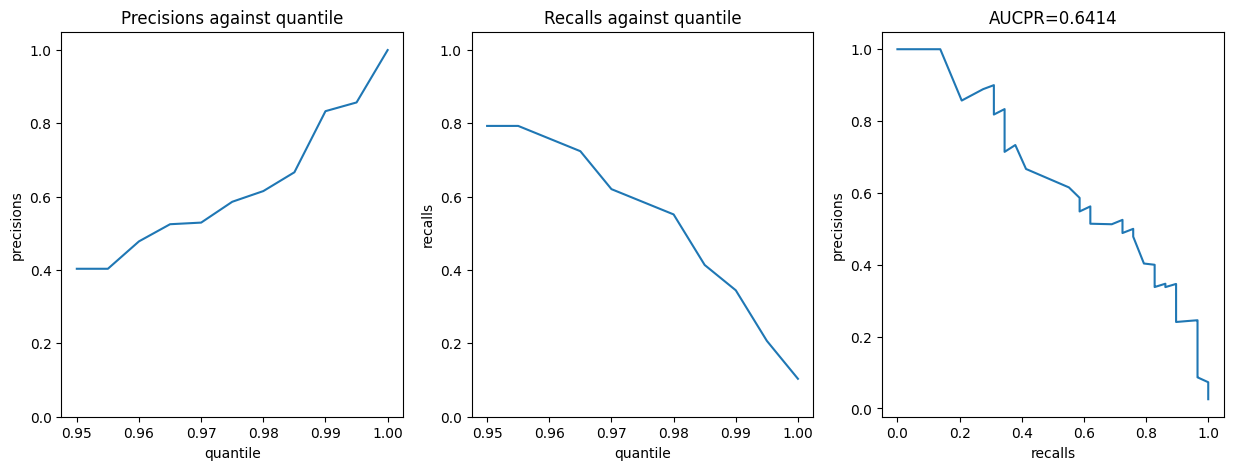

In [12]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_std, X_test_std = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns), scaler.transform(X_test)
 
features = [
  #'maxScore20m',
#   'maxScore21_40m',
  'maxScore41_60m',
  #'maxNumComments20m',
  'maxNumComments21_40m',
  'maxNumComments41_60m',
#   'maxUpvoteRatio20m', 
#   'maxUpvoteRatio21_40m',
  'maxUpvoteRatio41_60m',
#   'maxNumGildings20m',  # we know these are bad features from prior analysis
#   'maxNumGildings21_40m',
#   'maxNumGildings41_60m',
  'maxScoreGrowth21_40m41_60m',
  'maxNumCommentsGrowth21_40m41_60m',
  'randomVar',
#   'time0006', 
#   'time0612',
#   'time1218',
#   'time1800',
#   'sunday'
]

X = df[features]
y = df['target']
print(f"total posts: {len(y)}, viral posts: {y.sum()}")  # how many targets are there, This is a highly imbalanced problem, only ~2.5% of posts in rising go viral

sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=0)
train_index, test_index = next(sss.split(X,y))
X_train, y_train, X_test, y_test = X.iloc[train_index], y.iloc[train_index], X.iloc[test_index], y.iloc[test_index]

y_pred_proba = modelMetrics(X_train, y_train, X_test, y_test)

This is a pretty good model so far. There seems to be evidence for removing the upvote ratio features. I ran an experiment without them (not shown here) and it seemed to perform well without them but I want to experiment more before making a decision.

In [13]:
print(sum(y_test))

29


In [14]:
# sorted top 10 predictions
sorted(list(zip(y_pred_proba, y_test)), key=lambda x:x[0])[::-1][:10]

[(0.6646363726374206, 1),
 (0.6646363726374206, 1),
 (0.6646363726374206, 1),
 (0.6429612871102689, 1),
 (0.6024965993790518, 1),
 (0.6024965993790518, 0),
 (0.6024965993790518, 1),
 (0.4956585679697745, 1),
 (0.4956585679697745, 1),
 (0.47174250475989055, 1)]

It is cool to see many of the posts being scored at the top.

In [15]:
# I wanted to see some data on the viral posts (why were some accurately predicted and some not)
# and the posts that had high viral probability but were considered non-viral
def getOriginalPostId(df, test_index, y_test, y_pred_proba, threshold, features):
  fullTestData = df.iloc[test_index].copy(deep=True)
  fullTestData['prediction'] = y_pred_proba
  fullTestData['link'] = fullTestData['postId'].apply(lambda x: "https://reddit.com/"+x)
  target1Indexes = np.where(y_test==1)[0]
  viralPosts = fullTestData[fullTestData['target']==1].sort_values('prediction', ascending=False)
  nonViralPosts = fullTestData[fullTestData['target']==0].sort_values('prediction', ascending=False)
  nonViralPosts = nonViralPosts[nonViralPosts['prediction']>=threshold]
  
  p = len(viralPosts)
  tp = len(viralPosts[viralPosts['prediction']>=threshold])
  fp = len(nonViralPosts)
    
  print(f"recall = {tp/p}")
  print(f"precision = {tp/(tp+fp)}")

  return pd.concat([viralPosts, nonViralPosts], axis=0)[['target', 'postId', 'link', 'prediction', 'createdTSUTC']+features]


In [16]:
getOriginalPostId(df, test_index, y_test, y_pred_proba, threshold=0.2, features=features)

recall = 0.5862068965517241
precision = 0.5483870967741935


,target,postId,link,prediction,createdTSUTC,maxScore41_60m,maxNumComments21_40m,maxNumComments41_60m,maxUpvoteRatio41_60m,maxScoreGrowth21_40m41_60m,maxNumCommentsGrowth21_40m41_60m,randomVar
3479,1,12z2v8n,https://reddit.com/12z2v8n,0.664636,2023-04-26 01:48:36+00:00,180.0,29.0,51.0,0.90,2.103448,0.758621,0
3651,1,135tlqe,https://reddit.com/135tlqe,0.664636,2023-05-02 16:56:49+00:00,301.0,13.0,41.0,0.90,2.762500,2.153846,0
1786,1,134omh1,https://reddit.com/134omh1,0.664636,2023-05-01 14:51:49+00:00,108.0,21.0,53.0,0.88,1.511628,1.523810,0
3659,1,12s2767,https://reddit.com/12s2767,0.642961,2023-04-19 16:40:28+00:00,167.0,17.0,39.0,0.95,1.879310,1.294118,0
5233,1,132gkp5,https://reddit.com/132gkp5,0.602497,2023-04-29 02:11:53+00:00,114.0,12.0,25.0,0.96,1.072727,1.083333,0
3096,1,13637rz,https://reddit.com/13637rz,0.602497,2023-05-02 22:59:56+00:00,89.0,12.0,16.0,0.96,1.342105,0.333333,0
3529,1,12lxody,https://reddit.com/12lxody,0.495659,2023-04-14 13:41:09+00:00,57.0,16.0,41.0,0.84,1.111111,1.562500,0
2247,1,12jijwn,https://reddit.com/12jijwn,0.495659,2023-04-12 11:07:02+00:00,52.0,6.0,16.0,0.87,1.080000,1.666667,0
263,1,131ch4k,https://reddit.com/131ch4k,0.471743,2023-04-28 00:29:45+00:00,56.0,12.0,16.0,0.95,0.931034,0.333333,0
1973,1,12iolqv,https://reddit.com/12iolqv,0.467947,2023-04-11 16:07:21+00:00,67.0,6.0,9.0,0.94,1.310345,0.500000,0


**Below notes are a little outdated and were from the Logistic Regression model, but some of it is still relevant.**

I created the above to spotcheck a few examples. The 2 that I failed to predict were both pretty viral (exceeding two I succeeded in predicting) despite having relatively weak metrics (3 comments after an hour, <25 upvotes after an hour). This shows that there is pretty good lag in posts going viral and that perhaps more than an hour is needed to accurately predict virality. Another thing I noticed was that those two posts were both about tragedies, so perhaps there there is something about tragedies going extremely viral but are slower to gain traction.

The three posts that were predicted to go viral but ultimately were not all had pretty high upvote counts after the first hour but must have lost traction afterwards, this is further evidence that maybe it would be better to extend the data collection another 30-60 minutes.

# SHAP analysis

For imbalanced datasets, I like to look at the SHAP values for the target of interest (viral posts).

In [17]:
import shap

/Users/ken/Documents/side_projects/RedditWork/Model/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


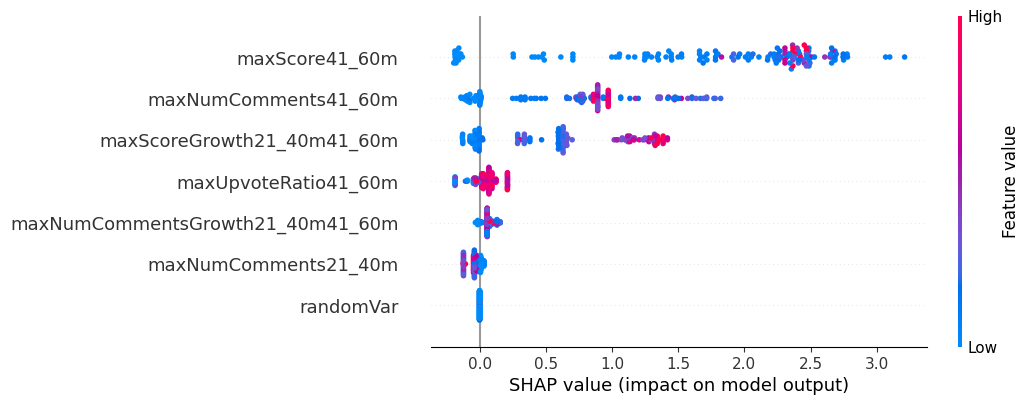

In [18]:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html
model = GradientBoostingClassifier(n_estimators=100, learning_rate=.01, min_samples_leaf=5, max_depth=3)
model.fit(X, y)
explainer = shap.Explainer(model, X, feature_names=X.columns)
shap_values = explainer(X)
shap_values_0 = explainer(X[y==0])
shap_values_1 = explainer(X[y==1])

shap.plots.beeswarm(shap_values_1, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
#ax.set_xlim(-3, 3) 
plt.show()

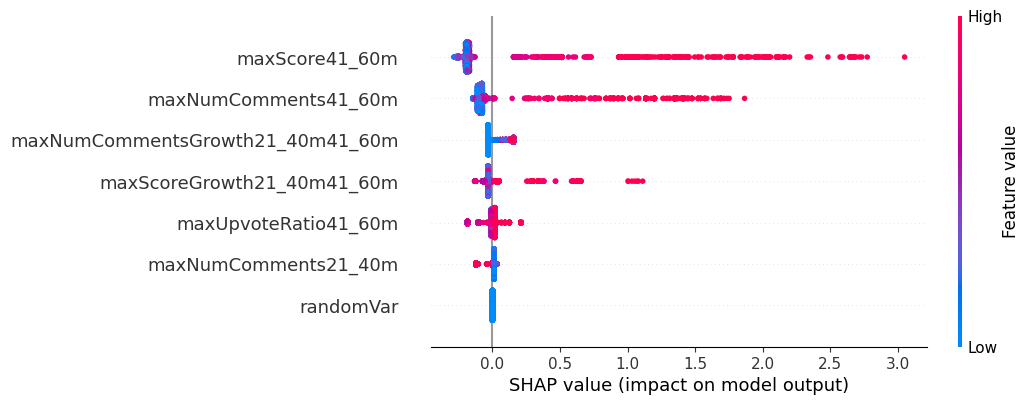

In [19]:
shap.plots.beeswarm(shap_values_0, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
#ax.set_xlim(-3, 3) 
plt.show()

<Axes: xlabel='mean(|SHAP value|)'>

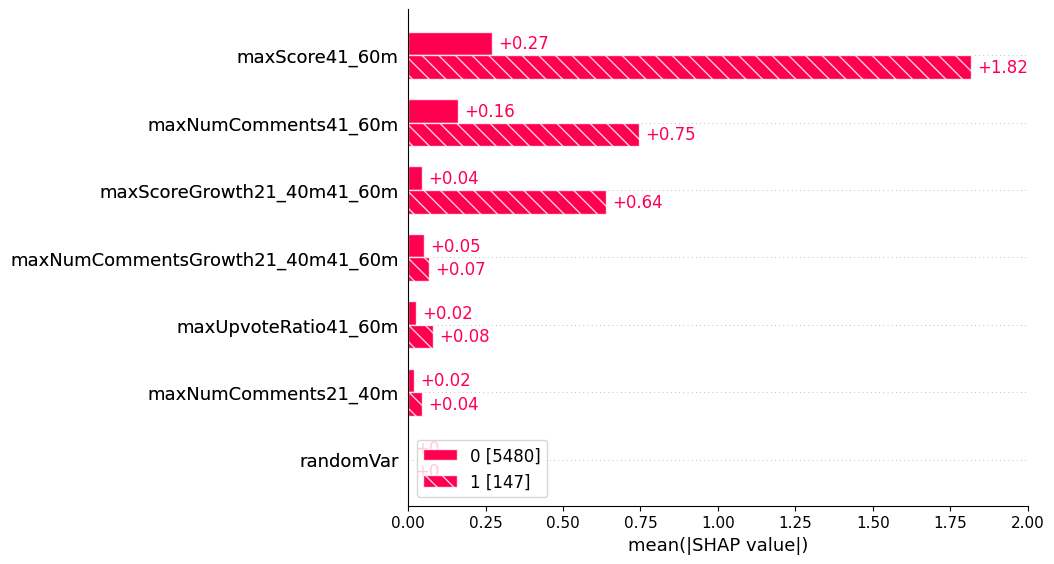

In [20]:
shap.plots.bar(shap_values.cohorts([i for i in map(str, y.values)]).abs.mean(0), show=False)

<Axes: xlabel='max(|SHAP value|)'>

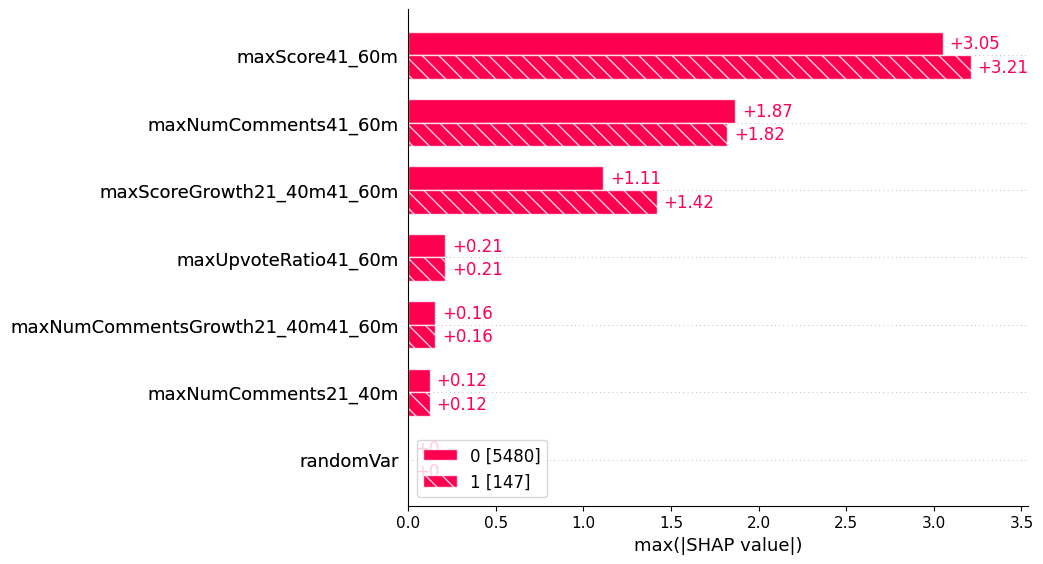

In [21]:
shap.plots.bar(shap_values.cohorts([i for i in map(str, y.values)]).abs.max(0), show=False)


# Grid search regularization parameter

Here I'm removing features based on the above findings, then I want to check how the model performs on different splits.

I'm removing the randomVar and the upvoteRatio features since they seem to be the least useful.

In [22]:
features = [
  #'maxScore20m',
#   'maxScore21_40m',
  'maxScore41_60m',
  #'maxNumComments20m',
  'maxNumComments21_40m',
  'maxNumComments41_60m',
#   'maxUpvoteRatio20m', 
#   'maxUpvoteRatio21_40m',
  'maxUpvoteRatio41_60m',
#   'maxNumGildings20m',  # we know these are bad features from prior analysis
#   'maxNumGildings21_40m',
#   'maxNumGildings41_60m',
  'maxScoreGrowth21_40m41_60m',
  'maxNumCommentsGrowth21_40m41_60m',
#   'randomVar',
#   'time0006', 
#   'time0612',
#   'time1218',
#   'time1800',
#   'sunday'
]

In [23]:
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

X = df[features]
y = df['target']
print(f"total posts: {len(y)}, viral posts: {y.sum()}")  # how many targets are there, This is a highly imbalanced problem, only ~2.5% of posts in rising go viral

sss = StratifiedShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
model = GradientBoostingClassifier()#(n_estimators=100, learning_rate=.01, min_samples_leaf=5, max_depth=3)
parameters = {
  'n_estimators':[50, 100, 150], 
  'learning_rate':[.1, .01, .001],
  'min_samples_leaf':[1,3,5,7],
  'max_depth':[2,3,4]
}

# parameters = {  # for debugging, comment out when not needed
#   'n_estimators':[50],
#   'learning_rate':[.1],
#   'min_samples_leaf':[1],
#   'max_depth':[2]
# }

# I couldn't figure out a way to make multiple scorers that don't repeat work, each scorer has to return a scaler
def getThreshold(y, y_pred, q=0.98):
  return np.quantile(y_pred, q)

def top2PctPrecision(y, y_pred):
  top2PctThreshold = getThreshold(y, y_pred)
  return y[y_pred>=top2PctThreshold].mean()
  
def top2PctRecall(y, y_pred):
  top2PctThreshold = getThreshold(y, y_pred)
  totalTargets = y.sum()
  return y[y_pred>=top2PctThreshold].sum()/totalTargets

def aucpr(y, y_pred):
  precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
  return auc(recalls, precisions)

def top5Pctaucpr(y, y_pred):
  """
  This is basically a partial aucpr for the top 5% where we are most likely to decision
  """
  top5PctThreshold = getThreshold(y, y_pred, q=0.95)
  y_pred2 = y_pred[y_pred >= top5PctThreshold]
  y2 = y[y_pred >= top5PctThreshold]
  precisions, recalls, thresholds = precision_recall_curve(y2, y_pred2)
  return auc(recalls, precisions)

top2PctPrecision_scorer = make_scorer(top2PctPrecision, needs_proba=True)
top2PctRecall_scorer = make_scorer(top2PctRecall, needs_proba=True)
aucpr_scorer = make_scorer(aucpr, needs_proba=True)
top5Pctaucpr_scorer = make_scorer(top5Pctaucpr, needs_proba=True)

scoring = {
  'top2PctPrecision':top2PctPrecision_scorer,
  'top2PctRecall':top2PctRecall_scorer,
  'aucpr':aucpr_scorer,
  'top5Pctaucpr': top5Pctaucpr_scorer,
}

gs = GridSearchCV(
  estimator=model,
  param_grid=parameters,
  scoring=scoring,
  cv=sss,
  n_jobs=-1,
  refit='top5Pctaucpr',
  verbose=3
  #, error_score="raise"  # uncomment this to test for scorer errors, changing n_jobs=1 can help
)
gs.fit(X,y)


total posts: 5627, viral posts: 147
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


/Users/ken/Documents/side_projects/RedditWork/Model/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2,
            train_size=0.8),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 4],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'n_estimators': [50, 100, 150]},
             refit='top5Pctaucpr',
             scoring={'aucpr': make_scorer(aucpr, response_method='predict_proba'),
                      'top2PctPrecision': make_scorer(top2PctPrecision, response_method='predict_proba'),
                      'top2PctRecall': make_scorer(top2PctRecall, response_method='predict_proba'),
                      'top5Pctaucpr': make_scorer(top5Pctaucpr, response_method='predict_proba')},
             verbose=3)

In [24]:
# this outputs a lot but it's used in the next steps
# gs.cv_results_

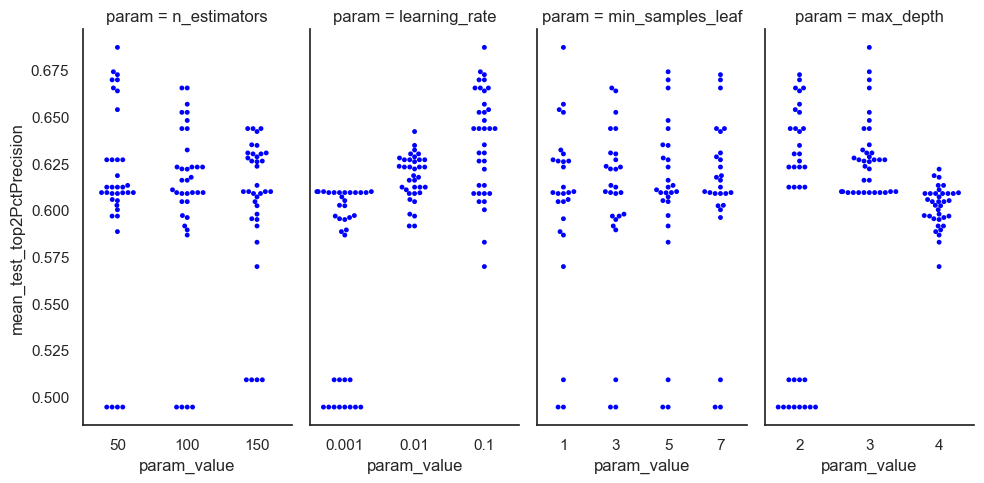

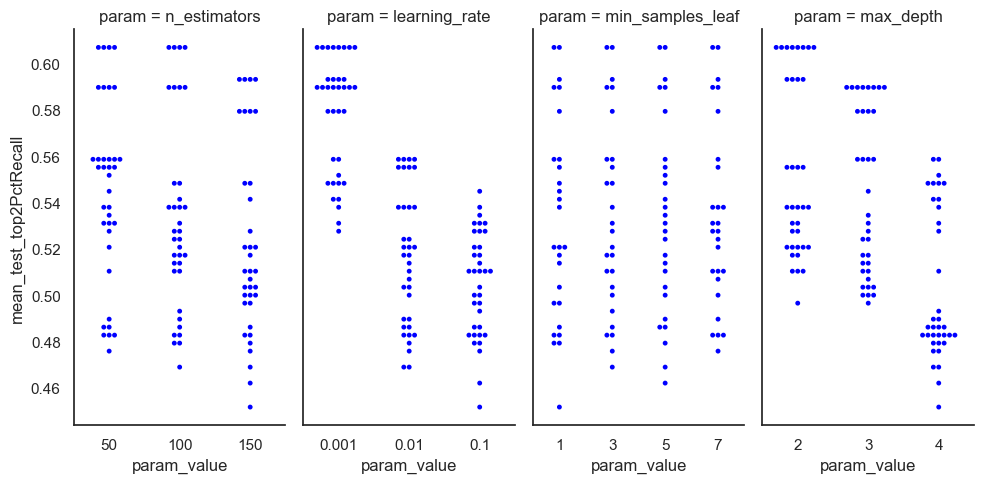

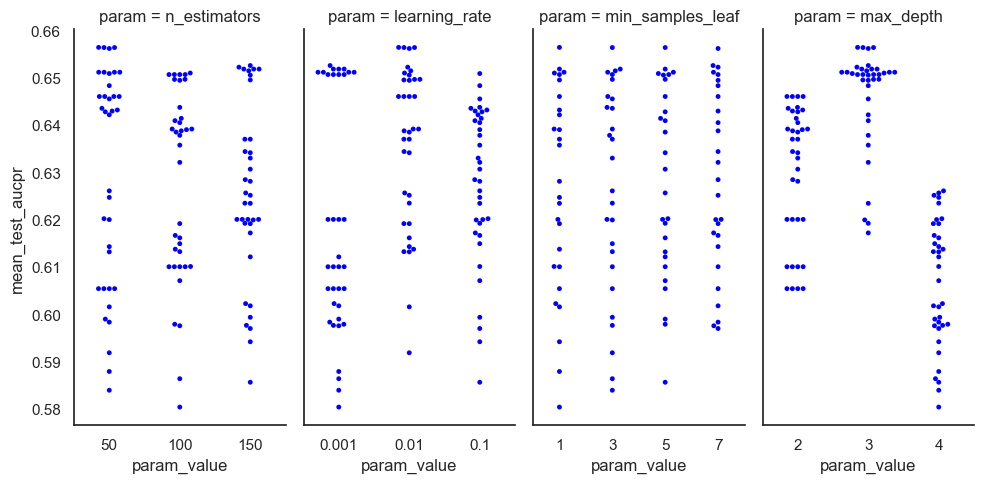

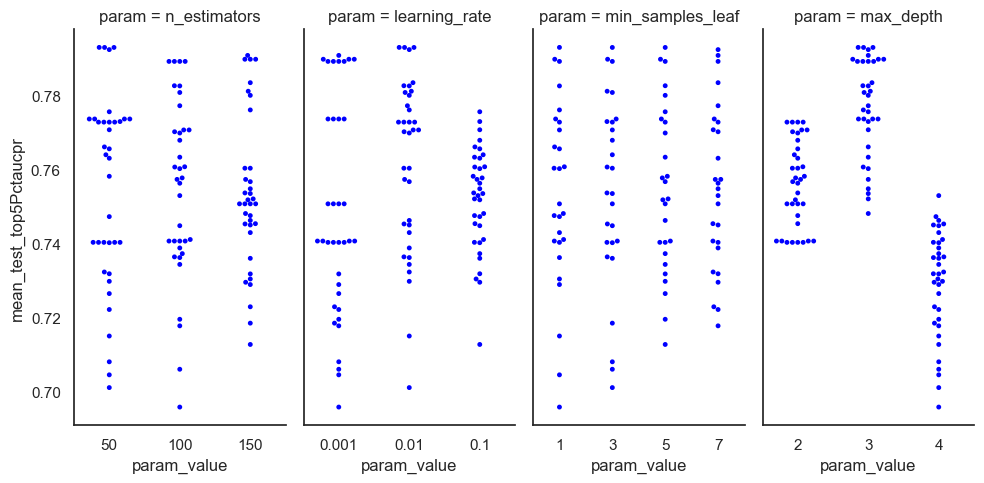

In [25]:
import seaborn as sns
sns.set_theme(style='white')

def swarmPlotForMetric(gs, metric=aucpr):
  metric_col = f'mean_test_{metric}'
  dfs = []
  for param in parameters.keys():
    sub_df = pd.DataFrame({
    'param': [param for _ in range(len(gs.cv_results_['param_min_samples_leaf'].data))], 
    'param_value':gs.cv_results_[f'param_{param}'].data,
    metric_col:gs.cv_results_[metric_col]
    })
    dfs.append(sub_df)

  data = pd.concat(dfs)

  sns.catplot(
    data=data, 
    kind="swarm",
    x="param_value", y=metric_col, col="param",
    aspect=.5,
    sharex=False,
    color='blue',
    s=3.5,
    facecolor='white'
  )
  plt.show()

swarmPlotForMetric(gs, 'top2PctPrecision')
swarmPlotForMetric(gs, 'top2PctRecall')
swarmPlotForMetric(gs, 'aucpr')
swarmPlotForMetric(gs, 'top5Pctaucpr')



# sns.swarmplot(data=data, x="min_samples_leaf", y="mean_test_aucpr")

In [26]:
print("best model params:", gs.best_params_)
print("best model aucpr:", gs.best_score_)

best model params: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 50}
best model aucpr: 0.7929563746137056


What I don't like about this model is I think having only 1 sample in the leaf risks overfitting. Let's look at the top 5 models:

In [27]:

mean_aucpr = np.array(gs.cv_results_['mean_test_aucpr'])
std_aucpr = np.array(gs.cv_results_['std_test_aucpr'])
params = np.array(gs.cv_results_['params'])

pd.set_option('display.max_colwidth', None)
d = pd.DataFrame(
  np.concatenate([mean_aucpr.reshape(-1,1), std_aucpr.reshape(-1,1), params.reshape(-1,1)], axis=1)
  , columns = ['mean aucpr', 'std aucpr', 'params']
  #, index=best5idx
)

d.sort_values('mean aucpr', ascending=False).head()

,mean aucpr,std aucpr,params
48,0.656392,0.066988,"{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 50}"
54,0.656361,0.066665,"{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 50}"
51,0.656361,0.066665,"{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 50}"
57,0.656159,0.066445,"{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 7, 'n_estimators': 50}"
95,0.652558,0.069292,"{'learning_rate': 0.001, 'max_depth': 3, 'min_samples_leaf': 7, 'n_estimators': 150}"


Couple of things that stand out here:

1. The only difference in the first 4 models is the min_samples_leaf
2. Furthermore in the swarm plots above we could see for the top5Pctaucpr metric, the min_samples_leaf has similar spreads for all values. However max_depth shows clear and distinctive distributions and likely has a stronger effect on the model.

Thus, although it risks overfitting, I'll keep it with min_samples_leaf = 1 since it seems to not have much difference among the best models.

# Create Final Model and Save Model

Final model is just going to use all of the data. This isn't typical practice but we don't have a lot of data so I want to use all of the data available. 

In [28]:

X = df[features]
y = df['target']
print(f"total posts: {len(y)}, viral posts: {y.sum()}")  # how many targets are there, This is a highly imbalanced problem, only ~2.5% of posts in rising go viral

params = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 50}
model = GradientBoostingClassifier(**params)
model.fit(X, y)


total posts: 5627, viral posts: 147


GradientBoostingClassifier(learning_rate=0.01, n_estimators=50)

In [31]:
import datetime

now = datetime.datetime.now(datetime.UTC).strftime('%Y%m%d-%H%M%S')
filename = f'./pickledModels/Reddit_model_{now}_GBM.sav'
pickle.dump(model, open(filename, 'wb'))

In [32]:
# testing the model
filename = './pickledModels/Reddit_model_20240426-075204_GBM.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict_proba(X)
print(result)

[[0.98341046 0.01658954]
 [0.98352997 0.01647003]
 [0.98352997 0.01647003]
 ...
 [0.98352997 0.01647003]
 [0.98352997 0.01647003]
 [0.98352997 0.01647003]]


# Upload Model to S3

In [33]:
import boto3

s3 = boto3.client('s3', region_name='us-east-2')

response = s3.upload_file(filename, "data-kennethmyers", f"models/{filename.split('/')[-1]}")

# Get Threshold of Top 1% of data

Really this should be done with a holdout set, but I don't have enough data right now so I'm just going to generate it from the in-sample data. We can always adjust the threshold later.

In [34]:
filename = './pickledModels/Reddit_model_20240426-075204_GBM.sav'
model = pickle.load(open(filename, 'rb'))

features = model.feature_names_in_
X = df[features]
y = df['target']
print(f"total posts: {len(y)}, viral posts: {y.sum()}")  # how many targets are there, This is a highly imbalanced problem, only ~2.5% of posts in rising go viral



total posts: 5627, viral posts: 147


Plots for top 5% of scores


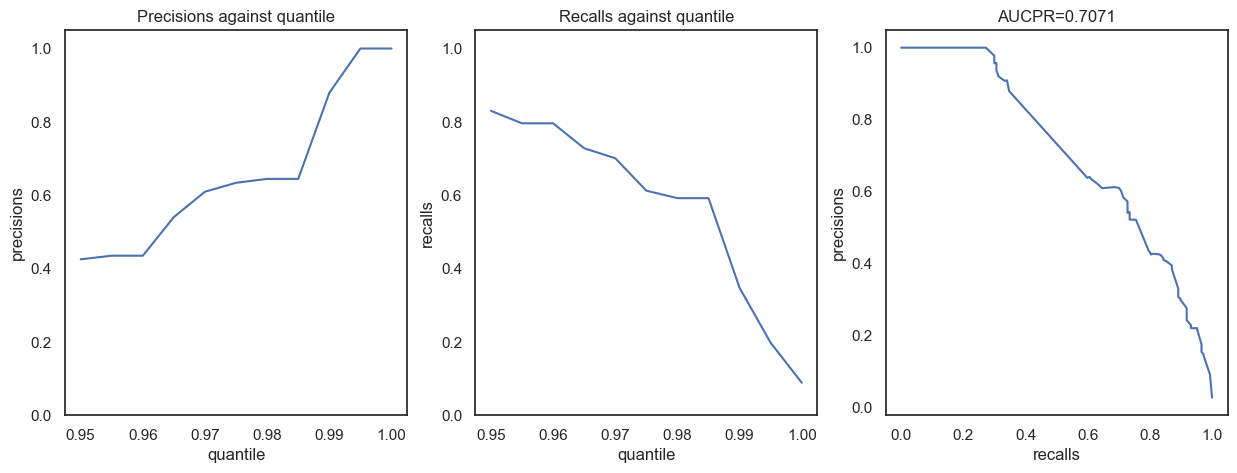

In [35]:
y_pred_proba = model.predict_proba(X[model.feature_names_in_])[:, 1]
plotPrecRecAUCPR(y=y, y_pred=y_pred_proba)

Taking the top ~1% to get higher precision and reduce spame from the subreddits this wasn't trained on.

In [36]:
threshold = np.quantile(y_pred_proba, 0.99)
threshold

0.2941209400738473

In [37]:
# this was defined earlier, not that it's overfit, because it's evaluating on trained data
getOriginalPostId(df, list(range(len(df))), y, y_pred_proba, threshold, list(features))

recall = 0.3469387755102041
precision = 0.8793103448275862


,target,postId,link,prediction,createdTSUTC,maxScore41_60m,maxNumComments21_40m,maxNumComments41_60m,maxUpvoteRatio41_60m,maxScoreGrowth21_40m41_60m,maxNumCommentsGrowth21_40m41_60m
3651,1,135tlqe,https://reddit.com/135tlqe,0.424945,2023-05-02 16:56:49+00:00,301.0,13.0,41.0,0.90,2.762500,2.153846
5069,1,12v4y7k,https://reddit.com/12v4y7k,0.424945,2023-04-22 12:47:21+00:00,417.0,16.0,30.0,0.96,1.424419,0.875000
2106,1,12q3ti7,https://reddit.com/12q3ti7,0.424945,2023-04-18 00:44:08+00:00,3070.0,47.0,191.0,0.93,5.278119,3.063830
1919,1,12mh34c,https://reddit.com/12mh34c,0.424945,2023-04-14 23:04:35+00:00,661.0,87.0,231.0,0.92,3.755396,1.655172
3479,1,12z2v8n,https://reddit.com/12z2v8n,0.424945,2023-04-26 01:48:36+00:00,180.0,29.0,51.0,0.90,2.103448,0.758621
...,...,...,...,...,...,...,...,...,...,...,...
5250,0,132itl0,https://reddit.com/132itl0,0.320919,2023-04-29 04:09:53+00:00,75.0,9.0,16.0,1.00,1.272727,0.777778
5105,0,12z0e15,https://reddit.com/12z0e15,0.310657,2023-04-25 23:57:03+00:00,111.0,3.0,7.0,0.94,0.947368,1.333333
803,0,12vs177,https://reddit.com/12vs177,0.306409,2023-04-23 02:15:49+00:00,81.0,7.0,14.0,0.93,1.076923,1.000000
131,0,12pg4tm,https://reddit.com/12pg4tm,0.294121,2023-04-17 13:33:03+00:00,65.0,7.0,12.0,0.97,1.096774,0.714286


If there are 250 posts per day reaching r/pics/rising, then this means we will find about 2.5 posts on average.

Of those 2.5 posts, 2 of them will be viral (0.8 precision) and this will be out of 7.5 posts that go viral (0.33 recall, those that reach top 3 of Hot). 

Once more data is collected this should be rerun to determine the proper out of sample scoring threshold.